## Predição da produtividade da cana-de-açúcar no estado de São Paulo

#### Parte 1: Análise exploratória e limpeza de dados de produtividade da cana-de-açúcar obtidos da página do IBGE

Nessa primeira parte iremos analisar os dados de produtividade para cada município. Os pasos consistem em separar o csv original em cada uma das tabelas e preencher os valores ausentes

In [38]:
# Carregar libraries
import numpy as np
import pandas as pd
import unicodecsv as csv
import matplotlib.pyplot as plt
import missingno
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [146]:
# Carregar dados e criar 'chunks' para cada tabela. Salvar separadamente no computador
for i, chunk in enumerate(pd.read_csv('tabela1612.csv',  encoding ='ISO-8859-1', decimal = ',', sep = ';', chunksize=648)):
    chunk.to_csv('chunk{}.csv'.format(i), index=False, encoding ='ISO-8859-1', decimal = '.')

No final da tabela original temos as descrições seguintes:

  - Zero absoluto, não resultante de um cálculo ou arredondamento (-) 
  - Zero resultante de um cálculo ou arredondamento (0)
  - Valor não se aplica. Ex: Não se pode obter o total da produção agrícola em determinado município quando os produtos agrícolas são contabilizados com unidades de medida distintas (..)
  - Valor não disponível. Ex: A produção de feijão em determinado município não foi pesquisada ou determinado município não existia no ano da pesquisa (...)
  
Após conferir os dados de produtividade com os dados de área plantada, foi possível observar que os municípios que não tem valores numéricos e apresentam algum dos símbolos mencionados acima, não possuem valor de produtivade por algúm dos motivos já mencionados, más principalmente porque não houve registro de área plantada. Então, iremos utilizar duas estratégias, sendo que a primeira será reemplazar todos os símbolos com espaço ou branco ou NaN que depois será preenchido com a média, para completar todos os espaços. A segunda estratégia será utilizar os dados com os NaNs.

O primeiro paso então é substituir os símbolos por 'NaN'


In [84]:
# Carregar a tabela que contem a produtividade da cana de açúcar para cada ano. Excluir as primeiras 4 linhas e as ultimas 2.
# Criar uma lista com os símbolos que representam os valores ausentes e utilizar esta lista para substituir NAs.
lista_ausentes = ['-', '..', '...']
dat = pd.read_csv("chunk5.csv", skiprows = 3, na_values = lista_ausentes).drop([0, 643, 644])
dat.head()

,Cód.,Município,2000,2001,2002,2003,2004,2005,2006,2007,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
1,3500105,Adamantina (SP),50000,80000,76311,77794,80000,81307,75000,100000,...,75000,60000,70000,60000,80000,80000,80000,70000,75000,70000
2,3500204,Adolfo (SP),NaN,80000,NaN,NaN,120000,89009,100000,100000,...,90000,90000,90000,70000,70000,80000,90000,90000,90000,90000
3,3500303,Aguaí (SP),80000,NaN,87000,86089,86000,85434,85000,85000,...,90000,90000,100000,100000,80000,90000,90000,85000,85000,85000
4,3500402,Águas da Prata (SP),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,60000,90000,90000,90000,NaN,NaN,NaN,NaN,NaN,NaN
5,3500501,Águas de Lindóia (SP),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [85]:
dat.shape

(642, 23)

In [86]:
dat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 642 entries, 1 to 642
Data columns (total 23 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Cód.       642 non-null    object
 1   Município  642 non-null    object
 2   2000       381 non-null    object
 3   2001       383 non-null    object
 4   2002       418 non-null    object
 5   2003       421 non-null    object
 6   2004       438 non-null    object
 7   2005       450 non-null    object
 8   2006       467 non-null    object
 9   2007       483 non-null    object
 10  2008       506 non-null    object
 11  2009       500 non-null    object
 12  2010       521 non-null    object
 13  2011       530 non-null    object
 14  2012       491 non-null    object
 15  2013       516 non-null    object
 16  2014       511 non-null    object
 17  2015       508 non-null    object
 18  2016       512 non-null    object
 19  2017       514 non-null    object
 20  2018       519 non-null    objec

Todas as colunas foram lidas como 'object'. Por isso precisamos converter para numerico

In [190]:
# Selecionar as colunas a converter
cols = dat.columns.drop(["Cód.", "Município"]).tolist()
cols

['2000',
 '2001',
 '2002',
 '2003',
 '2004',
 '2005',
 '2006',
 '2007',
 '2008',
 '2009',
 '2010',
 '2011',
 '2012',
 '2013',
 '2014',
 '2015',
 '2016',
 '2017',
 '2018',
 '2019',
 '2020']

In [88]:
# Converter colunas para tipo numerico
dat[cols] = dat[cols].apply(pd.to_numeric)
dat.head()

,Cód.,Município,2000,2001,2002,2003,2004,2005,2006,2007,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
1,3500105,Adamantina (SP),50000.0,80000.0,76311.0,77794.0,80000.0,81307.0,75000.0,100000.0,...,75000.0,60000.0,70000.0,60000.0,80000.0,80000.0,80000.0,70000.0,75000.0,70000.0
2,3500204,Adolfo (SP),NaN,80000.0,NaN,NaN,120000.0,89009.0,100000.0,100000.0,...,90000.0,90000.0,90000.0,70000.0,70000.0,80000.0,90000.0,90000.0,90000.0,90000.0
3,3500303,Aguaí (SP),80000.0,NaN,87000.0,86089.0,86000.0,85434.0,85000.0,85000.0,...,90000.0,90000.0,100000.0,100000.0,80000.0,90000.0,90000.0,85000.0,85000.0,85000.0
4,3500402,Águas da Prata (SP),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,60000.0,90000.0,90000.0,90000.0,NaN,NaN,NaN,NaN,NaN,NaN
5,3500501,Águas de Lindóia (SP),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [89]:
dat.shape

(642, 23)

In [90]:
dat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 642 entries, 1 to 642
Data columns (total 23 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Cód.       642 non-null    object 
 1   Município  642 non-null    object 
 2   2000       381 non-null    float64
 3   2001       383 non-null    float64
 4   2002       418 non-null    float64
 5   2003       421 non-null    float64
 6   2004       438 non-null    float64
 7   2005       450 non-null    float64
 8   2006       467 non-null    float64
 9   2007       483 non-null    float64
 10  2008       506 non-null    float64
 11  2009       500 non-null    float64
 12  2010       521 non-null    float64
 13  2011       530 non-null    float64
 14  2012       491 non-null    float64
 15  2013       516 non-null    float64
 16  2014       511 non-null    float64
 17  2015       508 non-null    float64
 18  2016       512 non-null    float64
 19  2017       514 non-null    float64
 20  2018      

In [91]:
# Descrever os dados
dat.describe()

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
count,381.000000,383.000000,418.000000,421.000000,438.000000,450.000000,467.000000,483.000000,506.000000,500.000000,...,530.000000,491.000000,516.000000,511.000000,508.000000,512.000000,514.000000,519.000000,518.000000,515.000000
mean,75104.435696,75308.028721,76572.440191,77986.137767,78883.949772,79697.422222,82600.933619,82760.086957,81830.237154,83436.128000,...,80818.015094,77962.959267,79305.798450,72675.874755,76010.992126,78120.646484,78526.655642,76118.510597,75444.432432,76552.504854
std,14495.151189,13403.233625,13235.901627,16007.396004,12854.484601,14299.738869,18373.835703,16359.525897,15927.510433,18037.357172,...,14442.579189,10483.770858,11879.309913,11713.637097,12066.415642,12746.845468,12467.961083,14014.284852,12272.952003,12128.665299
min,10000.000000,10000.000000,30000.000000,21676.000000,30000.000000,11955.000000,14000.000000,13000.000000,9000.000000,75.000000,...,100.000000,20819.000000,1200.000000,20000.000000,20000.000000,10000.000000,10000.000000,2000.000000,2000.000000,2000.000000
25%,70000.000000,70000.000000,70000.000000,70000.000000,71564.250000,74497.000000,75000.000000,75000.000000,75000.000000,78932.500000,...,74000.000000,70157.500000,73000.000000,65430.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
50%,75000.000000,77931.000000,80000.000000,80000.000000,80000.000000,79475.000000,80000.000000,80000.000000,81202.500000,83656.000000,...,80000.000000,80000.000000,80000.000000,71604.000000,75000.000000,80000.000000,80000.000000,79223.000000,75000.000000,78000.000000
75%,80000.000000,80000.000000,83913.500000,85000.000000,85856.250000,89396.000000,90000.000000,90000.000000,90000.000000,90000.000000,...,90000.000000,85000.000000,85000.000000,80000.000000,80000.000000,85000.000000,85000.000000,85000.000000,80000.000000,82000.000000
max,150000.000000,130000.000000,124900.000000,170764.000000,120000.000000,119423.000000,250000.000000,150000.000000,130000.000000,165000.000000,...,125000.000000,112073.000000,120049.000000,120000.000000,130000.000000,130000.000000,130000.000000,130000.000000,130000.000000,130000.000000


Na tabela acima podemos observar que não temos dados para todos os Municípios em todos os anos. Se completo, deveria ser 642 na linha 'count'. Portanto, vemos que há muitos dados faltantes. Como esses dados ausentes são produtos da não produção de cana naquele ano ou naquele municipio, a unica forma que podemos preencher é estudando as médias ou medianas por ano e por municipio. 

In [92]:
# Função para calcular o total de valores ausentes
def calc_ausentes(df):

    # Total de valores no dataset
    total_values = np.product(df.shape)

    # Numero de valores ausentes por coluna
    colvalues_missing = df.isnull().sum()

    # Total de valores ausentes e percentagem
    missing_total = colvalues_missing.sum()
    missing_percent = round(((missing_total/total_values) * 100), 2)

    # Print resultado
    print('O conjunto de dados tem {} % valores ausentes'.format(missing_percent))
    
    
# Função para calcular valores ausentes por coluna
def cal_ausentes_coluna(df):
    
    # Numero de valores ausentes por coluna
    col_missing = df.isnull().sum()

    # Porcentagem de valores ausentes
    col_missing_percent = 100 * col_missing / len(df)

    # Tipo de dado das colunas com valores ausentes
    col_missing_dtype = df.dtypes

    # Cria uma tabela com os resultados
    col_missing_table = pd.concat([col_missing, col_missing_percent, col_missing_dtype], axis=1)

    # Renomear as colunas
    col_missing_table = col_missing_table.rename(
    columns = {0 : 'Valores Ausentes', 1 : '% de Valores Ausentes', 2: 'Dtype'})

    # Classifica a tabela por porcentagem de valores ausentes de forma decrescente e remove colunas sem valores faltantes
    col_missing_table = col_missing_table[\
                                          col_missing_table.iloc[:,0] != 0].sort_values('% de Valores Ausentes', \
                                                                                        ascending = False).round(2)

    # Print 
    print ("O dataset tem " + str(df.shape[1]) + " colunas.\n"
        "Encontrado: " + str(col_missing_table.shape[0]) + " colunas que têm valores ausentes.")

    if col_missing_table.shape[0] == 0:
        return

    # Retorna o dataframe com informações ausentes
    return col_missing_table

# Função que calcula o percentual de linhas com valores ausentes
def calc_ausentes_linha(df):

    # Calcula o número total de linhas com valores ausentes
    missing_rows = sum([True for idx, row in df.iterrows() if any(row.isna())])

    # Calcula o número total de linhas
    total_rows = df.shape[0]

    # Calcula a porcentagem de linhas ausentes
    percen_ausentes = round(((missing_rows/total_rows) * 100), 2)
    
    print('O dataset tem {} % das linhas com pelo menos um valor ausente.'.format(percen_ausentes))

In [93]:
# Verifica o percentual de valores ausentes
calc_ausentes(dat)

O conjunto de dados tem 22.89 % valores ausentes


In [94]:
# Verificar os valores ausentes nas colunas
cal_ausentes_coluna(dat)      

O dataset tem 23 colunas.
Encontrado: 21 colunas que têm valores ausentes.


,Valores Ausentes,% de Valores Ausentes,Dtype
2000,261,40.65,float64
2001,259,40.34,float64
2002,224,34.89,float64
2003,221,34.42,float64
2004,204,31.78,float64
2005,192,29.91,float64
2006,175,27.26,float64
2007,159,24.77,float64
2012,151,23.52,float64
2009,142,22.12,float64


In [95]:
# Verificar os valores ausentes nas linhas
calc_ausentes_linha(dat)

O dataset tem 51.09 % das linhas com pelo menos um valor ausente.


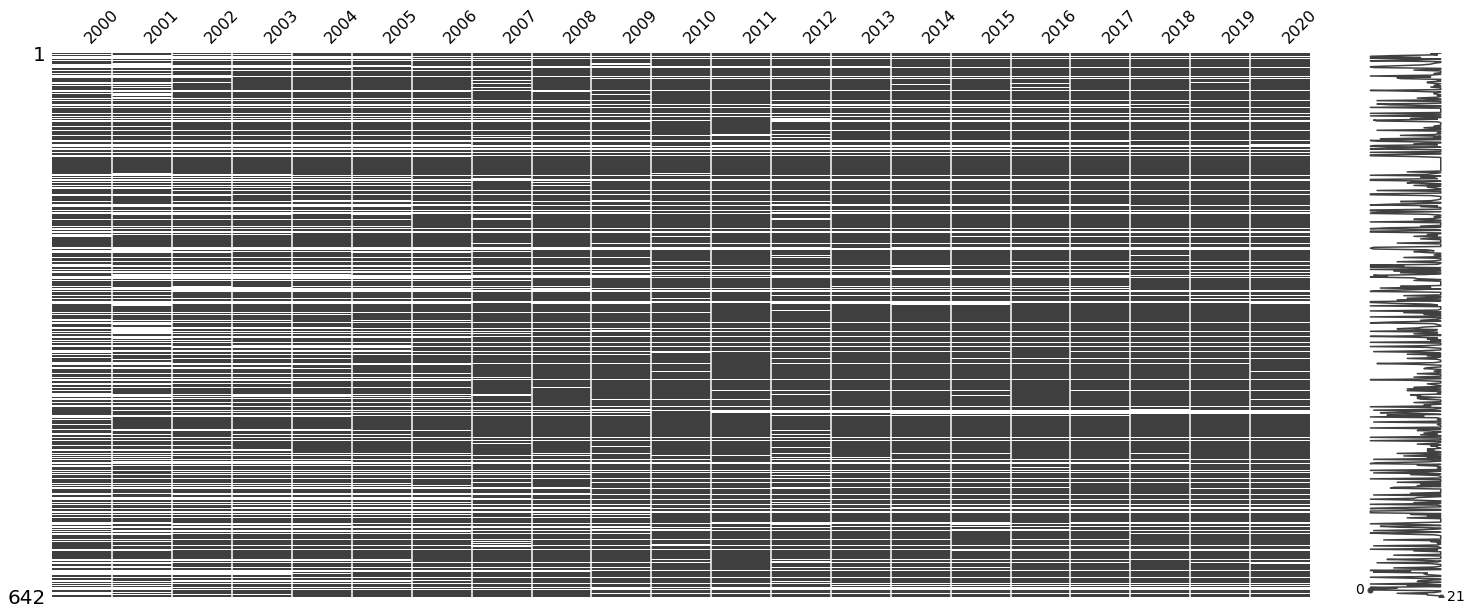

In [96]:
# Plotar mapa de valores ausentes
dat_nan = pd.DataFrame(dat.isna().sum())

if dat.isna().any(axis = None):
    missingno.matrix(dat[dat_nan[dat_nan[0]>0].index])
    plt.show()

Temos um padrão de variação nos dados. Há linhas inteiras com células vazias, o que quer dizer que vários municípios não produziram cana-de-açucar em nenhum dos anos estudados. Então, o paso seguinte é identificar a porcentagem desses valores ausentes em cada linha e coluna. A princípio iremos focar em deletar os valores ausentes nas linhas. Adotaremos a estratégia de eliminar municípios com mais de 40% de dados ausentes.

O que precisams fazer agora é contar os valores nulos para cada município, para ter certeza se são somente alguns valores faltando ou a porcentagem é maior. Se os valores ausentes em cada município representarem mais de 40%, o município será excluído da análise

In [149]:
# Contar as linhas com valores ausentes
missing_rows = sum([True for idx,row in dat.iterrows() if any(row.isna())])
print("Temos {} linhas com valores ausentes".format(missing_rows))

Temos 328 linhas com valores ausentes


In [150]:
## Criar um dataframe com o cálculo da porcentagem de valores ausentes para cada linha
rows_missing = dat.isnull().sum(axis=1)
rows_perc = round(((rows_missing / 21) * 100), 2)
mis_val_table = pd.concat([dat['Município'], rows_missing, rows_perc], axis = 1)
mis_val_table.rename(columns = {0: 'Total de ausentes', 1: 'Perc% de ausentes'}, inplace = True)
mis_val_table.head(7)

,Município,Total de ausentes,Perc% de ausentes
0,Adamantina (SP),0,0.00
1,Adolfo (SP),3,14.29
2,Aguaí (SP),1,4.76
3,Águas da Prata (SP),15,71.43
4,Águas de Lindóia (SP),21,100.00
5,Águas de Santa Bárbara (SP),6,28.57
6,Águas de São Pedro (SP),21,100.00


In [154]:
# Contar as linhas com 100% e > 50% de valores ausentes
rows_to_remove = mis_val_table[mis_val_table['Perc% de ausentes'] == 100].index.tolist()
rows_40perc = mis_val_table[mis_val_table['Perc% de ausentes'] >= 40.00].index.tolist()
print('Há {} linhas sem nenhum registro de produção de cana-de-açucar para todos os anos'.format(len(rows_to_remove)))
print('Há {} linhas com mais de 40% de valores ausentes'.format(len(rows_40perc)))

Há 68 linhas sem nenhum registro de produção de cana-de-açucar para todos os anos
Há 156 linhas com mais de 40% de valores ausentes


In [153]:
dat = dat.reset_index(drop=True)
dat

,Cód.,Município,2000,2001,2002,2003,2004,2005,2006,2007,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,3500105,Adamantina (SP),50000.0,80000.0,76311.0,77794.0,80000.0,81307.0,75000.0,100000.0,...,75000.0,60000.0,70000.0,60000.0,80000.0,80000.0,80000.0,70000.0,75000.0,70000.0
1,3500204,Adolfo (SP),NaN,80000.0,NaN,NaN,120000.0,89009.0,100000.0,100000.0,...,90000.0,90000.0,90000.0,70000.0,70000.0,80000.0,90000.0,90000.0,90000.0,90000.0
2,3500303,Aguaí (SP),80000.0,NaN,87000.0,86089.0,86000.0,85434.0,85000.0,85000.0,...,90000.0,90000.0,100000.0,100000.0,80000.0,90000.0,90000.0,85000.0,85000.0,85000.0
3,3500402,Águas da Prata (SP),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,60000.0,90000.0,90000.0,90000.0,NaN,NaN,NaN,NaN,NaN,NaN
4,3500501,Águas de Lindóia (SP),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
637,3557006,Votorantim (SP),NaN,70000.0,70000.0,70000.0,70000.0,69531.0,80000.0,69000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
638,3557105,Votuporanga (SP),NaN,NaN,NaN,NaN,80000.0,71799.0,90000.0,90000.0,...,50000.0,90000.0,77332.0,70000.0,70000.0,70000.0,75000.0,75000.0,70000.0,70000.0
639,3557154,Zacarias (SP),NaN,NaN,NaN,NaN,100000.0,99329.0,120000.0,120000.0,...,88240.0,88000.0,83016.0,70000.0,80000.0,80000.0,80000.0,80000.0,80000.0,80000.0
640,3557204,Chavantes (SP),150000.0,80000.0,70000.0,70000.0,70000.0,79474.0,80000.0,79450.0,...,80000.0,80000.0,80000.0,80000.0,75000.0,100000.0,90000.0,85000.0,80000.0,78960.0


In [155]:
dat.iloc[rows_40perc]

,Cód.,Município,2000,2001,2002,2003,2004,2005,2006,2007,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
3,3500402,Águas da Prata (SP),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,60000.0,90000.0,90000.0,90000.0,NaN,NaN,NaN,NaN,NaN,NaN
4,3500501,Águas de Lindóia (SP),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,3500600,Águas de São Pedro (SP),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,3500808,Alfredo Marcondes (SP),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,3501301,Álvares Machado (SP),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,75000.0,75000.0,75000.0,80000.0,100000.0,100000.0,100000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
630,3556453,Vargem Grande Paulista (SP),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
631,3556503,Várzea Paulista (SP),NaN,NaN,50000.0,50000.0,50000.0,52000.0,50000.0,50000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
632,3556602,Vera Cruz (SP),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
633,3556701,Vinhedo (SP),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Após verificarmos os valores ausentes, concluímos que serão removidas 138 linhas.

In [156]:
dat_clean = dat.drop(rows_40perc)
dat_clean.shape

(486, 23)

Vamos plotar de novo o grafico para conferir o padrão dos valores ausentes

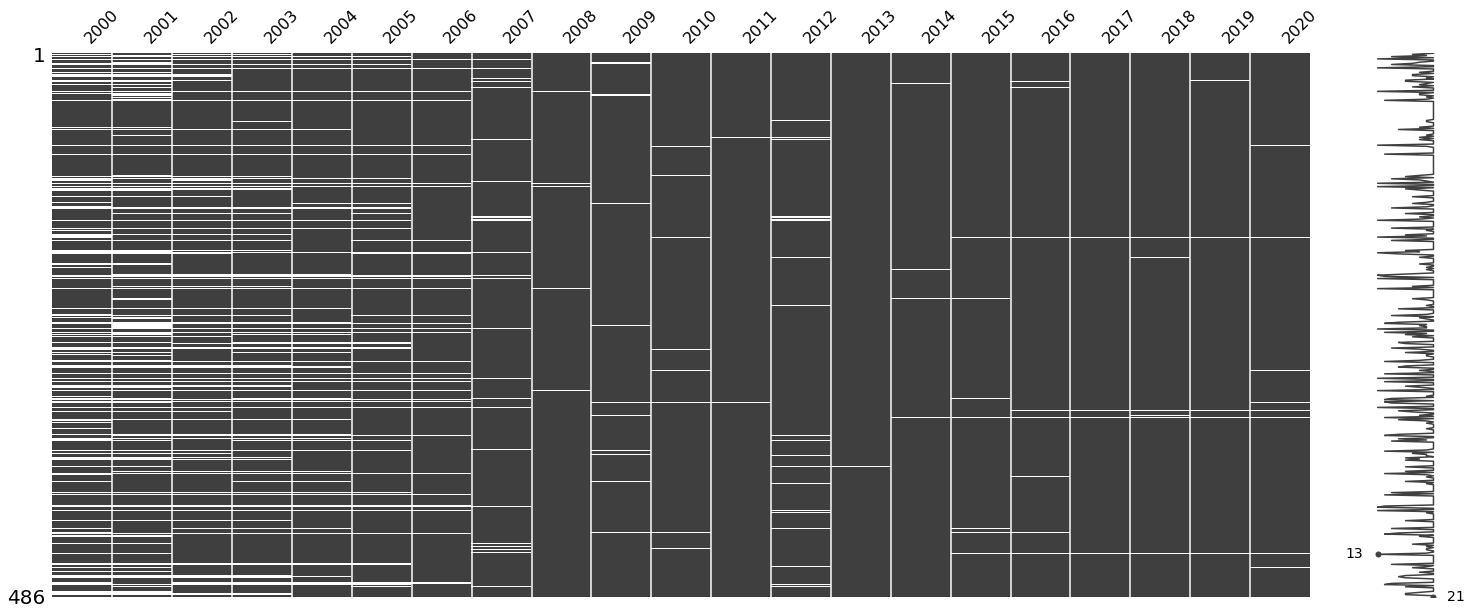

In [157]:
# Plot - Mapa de Valores Ausentes
dat_nan = pd.DataFrame(dat_clean.isna().sum())

if dat_clean.isna().any(axis = None):
    missingno.matrix(dat_clean[dat_nan[dat_nan[0]>0].index])
    plt.show()

In [158]:
# Contar as linhas com valores ausentes
missing_rows = sum([True for idx,row in dat_clean.iterrows() if any(row.isna())])
print("Temos {} linhas com valores ausentes". format(missing_rows))

Temos 172 linhas com valores ausentes


In [161]:
# Preencher com a média da produtividade de cada linha
m = dat_clean.mean(axis=1)
for i, column in enumerate(dat_clean):
    dat_clean.iloc[:, i] = dat_clean.iloc[:, i].fillna(m)
    
dat_clean.head()

,Cód.,Município,2000,2001,2002,2003,2004,2005,2006,2007,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,3500105,Adamantina (SP),50000.000000,80000.000000,76311.000000,77794.000000,80000.000000,81307.000000,75000.0,100000.0,...,75000.0,60000.0,70000.0,60000.0,80000.0,80000.0,80000.0,70000.0,75000.0,70000.0
1,3500204,Adolfo (SP),88833.833333,80000.000000,88833.833333,88833.833333,120000.000000,89009.000000,100000.0,100000.0,...,90000.0,90000.0,90000.0,70000.0,70000.0,80000.0,90000.0,90000.0,90000.0,90000.0
2,3500303,Aguaí (SP),80000.000000,88180.150000,87000.000000,86089.000000,86000.000000,85434.000000,85000.0,85000.0,...,90000.0,90000.0,100000.0,100000.0,80000.0,90000.0,90000.0,85000.0,85000.0,85000.0
5,3500550,Águas de Santa Bárbara (SP),80132.266667,80132.266667,80132.266667,80132.266667,80132.266667,80132.266667,80333.0,80000.0,...,80000.0,100000.0,100000.0,100000.0,90000.0,63000.0,80000.0,70000.0,75000.0,55000.0
7,3500709,Agudos (SP),70000.000000,70000.000000,70000.000000,70000.000000,77996.000000,77723.000000,80000.0,88669.0,...,79500.0,79500.0,79500.0,60004.0,64794.0,61000.0,70000.0,61000.0,70000.0,70000.0


In [162]:
# Contar as linhas com valores ausentes após o preenchimento com a média
missing_rows = sum([True for idx,row in dat_clean.iterrows() if any(row.isna())])
print("Temos {} linhas com valores ausentes". format(missing_rows))

Temos 0 linhas com valores ausentes


In [163]:
dat_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 486 entries, 0 to 641
Data columns (total 23 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Cód.       486 non-null    object 
 1   Município  486 non-null    object 
 2   2000       486 non-null    float64
 3   2001       486 non-null    float64
 4   2002       486 non-null    float64
 5   2003       486 non-null    float64
 6   2004       486 non-null    float64
 7   2005       486 non-null    float64
 8   2006       486 non-null    float64
 9   2007       486 non-null    float64
 10  2008       486 non-null    float64
 11  2009       486 non-null    float64
 12  2010       486 non-null    float64
 13  2011       486 non-null    float64
 14  2012       486 non-null    float64
 15  2013       486 non-null    float64
 16  2014       486 non-null    float64
 17  2015       486 non-null    float64
 18  2016       486 non-null    float64
 19  2017       486 non-null    float64
 20  2018      

In [164]:
dat_clean.to_csv("dados_limpos.csv")

Assim finalizamos a primeira parte da nossa análise

#### Parte 2: Analisando os dados

Vamos a começar vendo as estatísticas básicas tanto para as colunas como para as linhas. Para o caso das linhas, a média dos 21 anos será calculada para cada Município.

In [165]:
# Estatísticas básicas por coluna
dat_clean.describe()

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
count,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,...,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000
mean,76969.216042,77245.848056,78014.798957,79176.602327,79766.746129,80739.045673,83399.601383,83157.650639,82941.597024,83876.446316,...,81896.514540,78154.541909,80051.778988,72811.426091,76257.245947,78711.396332,78926.312514,77559.787498,76582.421689,77687.072726
std,12898.950875,11865.918788,12371.588392,14716.252123,11815.924800,13009.541100,17311.295933,15345.475541,14528.738645,15218.409055,...,12338.970492,10049.245832,10301.454938,11155.879673,11482.163119,11546.532605,11413.381125,11367.057610,9691.342796,9792.380230
min,30000.000000,10000.000000,35000.000000,21676.000000,30000.000000,11955.000000,14000.000000,13000.000000,9000.000000,11000.000000,...,10000.000000,20819.000000,50000.000000,33000.000000,35000.000000,31699.000000,50000.000000,45000.000000,40000.000000,48000.000000
25%,70000.000000,70000.000000,70000.000000,70616.500000,73745.000000,74506.500000,75000.000000,75000.000000,79190.250000,80000.000000,...,75000.000000,71000.000000,74813.500000,65430.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
50%,77832.872917,80000.000000,80000.000000,80000.000000,80000.000000,79522.000000,80000.000000,80000.000000,82618.000000,83217.500000,...,80000.000000,80000.000000,80000.000000,72000.000000,75000.000000,80000.000000,80000.000000,80000.000000,76000.000000,78960.000000
75%,83854.110714,82856.474790,85000.000000,85851.698317,87375.000000,89396.000000,90000.000000,90000.000000,90000.000000,90000.000000,...,90000.000000,85000.000000,85000.000000,80000.000000,80000.000000,85000.000000,85000.000000,85000.000000,80244.942308,82000.000000
max,150000.000000,130000.000000,124900.000000,170764.000000,120000.000000,119423.000000,250000.000000,150000.000000,130000.000000,150000.000000,...,125000.000000,112073.000000,120049.000000,120000.000000,130000.000000,130000.000000,130000.000000,130000.000000,130000.000000,130000.000000


In [181]:
# Calculando a média de cada Município
dat_clean['mean'] = round(dat_clean.mean(axis=1),2)
dat_clean.head()

,Cód.,Município,2000,2001,2002,2003,2004,2005,2006,2007,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,mean
0,3500105,Adamantina (SP),50000.000000,80000.000000,76311.000000,77794.000000,80000.000000,81307.000000,75000.0,100000.0,...,60000.0,70000.0,60000.0,80000.0,80000.0,80000.0,70000.0,75000.0,70000.0,75733.90
1,3500204,Adolfo (SP),88833.833333,80000.000000,88833.833333,88833.833333,120000.000000,89009.000000,100000.0,100000.0,...,90000.0,90000.0,70000.0,70000.0,80000.0,90000.0,90000.0,90000.0,90000.0,88833.83
2,3500303,Aguaí (SP),80000.000000,88180.150000,87000.000000,86089.000000,86000.000000,85434.000000,85000.0,85000.0,...,90000.0,100000.0,100000.0,80000.0,90000.0,90000.0,85000.0,85000.0,85000.0,88180.15
5,3500550,Águas de Santa Bárbara (SP),80132.266667,80132.266667,80132.266667,80132.266667,80132.266667,80132.266667,80333.0,80000.0,...,100000.0,100000.0,100000.0,90000.0,63000.0,80000.0,70000.0,75000.0,55000.0,80132.27
7,3500709,Agudos (SP),70000.000000,70000.000000,70000.000000,70000.000000,77996.000000,77723.000000,80000.0,88669.0,...,79500.0,79500.0,60004.0,64794.0,61000.0,70000.0,61000.0,70000.0,70000.0,73318.38


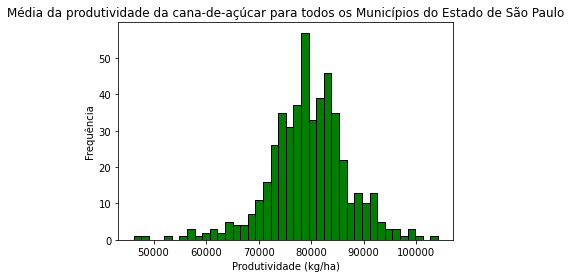

In [182]:
# Histograma da média da produtividade para cada município
plt.hist(dat_clean['mean'], bins = 40, facecolor='green', edgecolor = 'black')
plt.title('Média da produtividade da cana-de-açúcar para todos os Municípios do Estado de São Paulo')
plt.xlabel('Produtividade (kg/ha)')
plt.ylabel('Frequência')
plt.show()

É possível observar que a maioria dos municípios apresentam média em torno de 80000 kg/ha.

Agora vamos explorar formas de agrupar nossos dados para diminuir o número de observações. Eu pensei primeiro em calcular cinco quantiles e agrupar os municípios em função destes quantiles. Vamos ver como fica

In [230]:
# Calculando os quantiles
dat_clean['quantiles'] = pd.qcut(x=dat_clean['mean'], q=5, labels=False)
dat_clean.sort_values('quantiles')

,Cód.,Município,2000,2001,2002,2003,2004,2005,2006,2007,...,2013,2014,2015,2016,2017,2018,2019,2020,mean,quantiles
216,3519071,Hortolândia (SP),61763.923077,60000.000000,60000.000000,60000.000000,60000.000000,59598.000000,60000.000000,60000.0,...,60000.0,83333.0,61763.923077,61763.923077,61763.923077,61763.923077,61763.923077,61763.923077,61763.92,0
174,3515350,Euclides da Cunha Paulista (SP),50000.000000,60000.000000,50000.000000,50000.000000,67993.833333,67993.833333,70000.000000,70000.0,...,80000.0,70000.0,68752.000000,64742.000000,70000.000000,70000.000000,72811.000000,69584.000000,67993.83,0
455,3540853,Pracinha (SP),60000.000000,80000.000000,89642.000000,86514.000000,75000.000000,74529.000000,70000.000000,70000.0,...,70000.0,70000.0,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,71699.29,0
320,3528700,Marabá Paulista (SP),60000.000000,73390.950000,70000.000000,70000.000000,70000.000000,79464.000000,83000.000000,83000.0,...,70000.0,75000.0,76989.000000,71820.000000,70000.000000,70000.000000,72273.000000,72273.000000,73390.95,0
218,3519204,Iacri (SP),55343.000000,55343.000000,98628.000000,72280.000000,78668.000000,91762.000000,70000.000000,70000.0,...,70000.0,70000.0,75000.000000,75000.000000,68000.000000,70000.000000,61000.000000,69800.000000,72896.38,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445,3540101,Pongaí (SP),80000.000000,92639.071429,92639.071429,92639.071429,92639.071429,92639.071429,92639.071429,100000.0,...,100000.0,100000.0,80000.000000,100000.000000,100000.000000,80000.000000,70000.000000,86947.000000,92639.07,4
447,3540259,Pontalinda (SP),90000.000000,30000.000000,60000.000000,91538.000000,90000.000000,79462.000000,80000.000000,72500.0,...,88016.0,80000.0,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,86519.81,4
449,3540408,Populina (SP),86115.250000,80000.000000,80000.000000,75464.000000,80000.000000,79523.000000,100000.000000,96428.0,...,90000.0,80000.0,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,86115.25,4
454,3540804,Potirendaba (SP),100000.000000,100000.000000,75000.000000,75000.000000,80000.000000,110445.000000,100000.000000,100000.0,...,85000.0,79000.0,80000.000000,80000.000000,100000.000000,90000.000000,83333.000000,80000.000000,88703.71,4


In [243]:
dat_clean.loc[dat_clean['quantiles'] == 4]

,Cód.,Município,2000,2001,2002,2003,2004,2005,2006,2007,...,2013,2014,2015,2016,2017,2018,2019,2020,mean,quantiles
1,3500204,Adolfo (SP),88833.833333,80000.000000,88833.833333,88833.833333,120000.000000,89009.000000,100000.0,100000.0,...,90000.0,70000.0,70000.0,80000.0,90000.0,90000.0,90000.0,90000.0,88833.83,4
2,3500303,Aguaí (SP),80000.000000,88180.150000,87000.000000,86089.000000,86000.000000,85434.000000,85000.0,85000.0,...,100000.0,100000.0,80000.0,90000.0,90000.0,85000.0,85000.0,85000.0,88180.15,4
21,3501905,Amparo (SP),90000.000000,90000.000000,100000.000000,100000.000000,90000.000000,99360.000000,110000.0,110000.0,...,80000.0,72628.0,60000.0,60000.0,60000.0,60000.0,60000.0,60000.0,86285.14,4
24,3502200,Angatuba (SP),87597.473684,87597.473684,112982.000000,82271.000000,83000.000000,74732.000000,70152.0,75000.0,...,100000.0,78000.0,100000.0,100000.0,100000.0,85000.0,85000.0,90000.0,87597.47,4
32,3502903,Araçoiaba da Serra (SP),70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,99328.000000,100000.0,85025.2,...,100000.0,100000.0,100000.0,80000.0,80000.0,80000.0,80000.0,80000.0,85025.20,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
623,3555901,Uru (SP),98572.785714,98572.785714,98572.785714,98572.785714,98572.785714,98572.785714,80000.0,50000.0,...,120049.0,99972.0,120000.0,120013.0,120000.0,110000.0,75000.0,75000.0,98572.79,4
629,3556404,Vargem Grande do Sul (SP),91000.000000,90000.000000,87000.000000,80586.000000,81000.000000,81450.000000,85000.0,90000.0,...,90138.0,89988.0,75278.0,119995.0,120000.0,120000.0,90000.0,75000.0,90861.24,4
635,3556909,Vista Alegre do Alto (SP),100000.000000,100000.000000,102857.000000,100000.000000,90000.000000,89396.000000,76500.0,76000.0,...,100000.0,82000.0,99540.0,96000.0,90000.0,95000.0,90000.0,87000.0,90193.05,4
636,3556958,Vitória Brasil (SP),97532.684211,97532.684211,80000.000000,58344.000000,80000.000000,99328.000000,140000.0,119259.0,...,95000.0,90000.0,100000.0,100000.0,100000.0,100000.0,85000.0,100000.0,97532.68,4


In [259]:
dat_4 = dat_clean.loc[dat_clean['quantiles'] == 1]
dat_4['Município'].tolist()

In [231]:
# Agrupando os quantiles
dat_clean_grouped = dat_clean.groupby('quantiles').mean()
dat_clean_grouped

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,mean
quantiles,,,,,,,,,,,,,,,,,,,,,
0,65689.405065,66928.397849,64586.252946,65335.505960,66417.963443,66583.840712,68636.594248,68331.955615,69736.046311,69913.869946,...,70675.879752,72214.189676,67585.819242,70042.259954,70235.056702,70495.438355,69796.856722,70673.673049,70561.334166,68859.021939
1,74136.752898,74009.131951,75326.924816,77255.916417,77653.530314,78578.681032,81158.487059,79762.871864,79175.876289,78434.456958,...,75193.764890,77417.969072,70208.578866,73022.197809,75588.826160,74932.422680,73599.225176,73762.351122,74876.649485,76279.598454
2,75953.380127,78551.613252,79403.187138,78891.139601,80367.775138,80778.021272,81064.812337,84840.245211,84086.958763,85096.178658,...,78868.060119,79548.969072,71524.886598,75346.597145,78149.834259,78927.009516,77714.844568,76478.813640,77647.538268,79608.211031
3,80803.980845,79675.637790,81388.950703,83086.462158,84741.045542,86370.695027,87204.292965,88273.967526,87555.582078,89133.793814,...,81059.453608,83121.051546,75615.842268,79201.556701,82645.402062,82559.773196,80277.041237,79094.762887,80077.065821,83044.961959
4,88378.847987,87170.824907,89507.117801,91456.679212,89791.032524,91529.920271,99086.016257,94732.055194,94289.661380,96947.876289,...,85052.650787,88037.515464,79175.875716,83737.690149,87025.247423,87803.835052,86491.000000,82963.422680,85346.237113,89427.298247


In [281]:
dat_clean_grouped_trans = dat_clean_grouped.T
dat_clean_grouped_trans.reset_index(inplace = True)
dat_clean_grouped_trans.rename(columns = {'index': 'YEAR', 0: 'q1', 1: 'q2', 2:'q3', 3:'q4', 4:'q5'}, inplace = True)
dat_clean_grouped_trans.drop(21, inplace = True)
dat_clean_grouped_trans['YEAR'] = pd.to_datetime(dat_clean_grouped_trans['YEAR'])
dat_clean_grouped_trans

quantiles,YEAR,q1,q2,q3,q4,q5
0,2000-01-01,65689.405065,74136.752898,75953.380127,80803.980845,88378.847987
1,2001-01-01,66928.397849,74009.131951,78551.613252,79675.637790,87170.824907
2,2002-01-01,64586.252946,75326.924816,79403.187138,81388.950703,89507.117801
3,2003-01-01,65335.505960,77255.916417,78891.139601,83086.462158,91456.679212
4,2004-01-01,66417.963443,77653.530314,80367.775138,84741.045542,89791.032524
5,2005-01-01,66583.840712,78578.681032,80778.021272,86370.695027,91529.920271
6,2006-01-01,68636.594248,81158.487059,81064.812337,87204.292965,99086.016257
7,2007-01-01,68331.955615,79762.871864,84840.245211,88273.967526,94732.055194
8,2008-01-01,69736.046311,79175.876289,84086.958763,87555.582078,94289.661380
9,2009-01-01,69913.869946,78434.456958,85096.178658,89133.793814,96947.876289


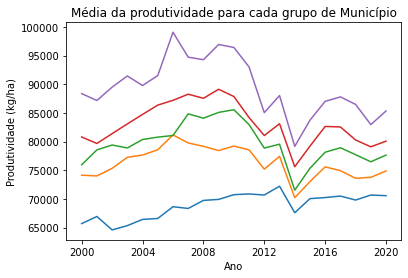

In [292]:
plt.plot(dat_clean_grouped_trans['YEAR'], dat_clean_grouped_trans['q1'])
plt.plot(dat_clean_grouped_trans['YEAR'], dat_clean_grouped_trans['q2'])
plt.plot(dat_clean_grouped_trans['YEAR'], dat_clean_grouped_trans['q3'])
plt.plot(dat_clean_grouped_trans['YEAR'], dat_clean_grouped_trans['q4'])
plt.plot(dat_clean_grouped_trans['YEAR'], dat_clean_grouped_trans['q5'])
plt.title('Média da produtividade para cada grupo de Município')
plt.xlabel('Ano')
plt.ylabel('Produtividade (kg/ha)')
plt.savefig('plot_avergae_yield.png', dpi=80)

plt.show()


In [ ]:
## Plot mean and standard deviation
mean_plus_st = mean_st_merged['mean_yield'] +  mean_st_merged['st_yield']
mean_minus_st = mean_st_merged['mean_yield'] -  mean_st_merged['st_yield']

plt.figure(figsize=(7, 5), dpi=300)
plt.plot(mean_st_merged['YEAR_x'], mean_st_merged['mean_yield'], color = 'blue')
plt.fill_between(mean_st_merged['YEAR_x'], mean_plus_st, mean_minus_st, alpha = 0.2, color = 'blue')
plt.title("Average Sugarcane Yield (kg/ha) from São Paulo State")
plt.xlabel("YEAR")
plt.ylabel("Yield (kg/ha)")
plt.savefig('plot_avergae_st_yield.png', dpi=80)

plt.show()